The goal of this exercise is to predict vehicle sale prices (Sold_Amount). Prepare a report documenting your thought
process in building out the prediction model. The process should display some of the following considerations:

    • Data understanding, including highlighting errors and concerns with the data.
    • Features to select and/or engineer. Take note that you cannot use the following fields:
      AvgWholesale, AvgRetail, GoodWholesale, GoodRetail, TradeMin, TradeMax, PrivateMax
    • Experimentation with various feature encoding and modeling techniques.
    • Report model performance on test dataset and do not drop any rows in the test dataset.
    • Different ways of evaluating the performance of the model and diagnosing the model for areas where it
      may be underperforming.
      
You can use Jupyter Notebooks for the report, but feel free to experiment with different Python libraries apart from
the generic Scikit-learn and scientific libraries. For the sake of managing your experiments, feel free to play with
tools like MLFlow. If you wish to focus the exercise more on engineering and deploying the model, you can keep
the modeling process basic but demonstrate the use of tools like Seldon and Kubeflow for training and
productionizing models.

Please place all code and logs in a .git repository with README files for executing the code or any demo if
necessary.

In [1]:
##import necessary library
import pandas as pd
from operator import itemgetter
import missingno as msno
import numpy as np
from sklearn.impute import SimpleImputer
from pickle import dump, load
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, explained_variance_score, r2_score
from sklearn.svm import SVR
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from sklearn.ensemble import RandomForestRegressor

### Set mlflow
Resource: https://github.com/mtpatter/mlflow-tutorial/blob/main/mlflow-sklearn.ipynb

#### You need to start mlflow server first  via cmd with this command 
<i>mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts --host localhost</i>

In [2]:
mlflow.set_tracking_uri("http://127.0.0.1:5000") ## check your localhost IP
mlflow.set_experiment("my-experiment")

<Experiment: artifact_location='./artifacts/1', creation_time=1666449730263, experiment_id='1', last_update_time=1666449730263, lifecycle_stage='active', name='my-experiment', tags={}>

In [3]:
from mlflow.tracking import MlflowClient
client = MlflowClient()

### Read datasets

In [4]:
pd.set_option("display.max_columns", None)

In [5]:
##Read train and test data

train_dat = pd.read_csv('DatiumTrain.rpt', delimiter='\t')
test_dat = pd.read_csv('DatiumTest.rpt', delimiter='\t')

C:\Users\faizm\.conda\envs\test\lib\site-packages\IPython\core\interactiveshell.py:3258: DtypeWarning: Columns (27,94) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\faizm\.conda\envs\test\lib\site-packages\IPython\core\interactiveshell.py:3258: DtypeWarning: Columns (27,91) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
train_dat.describe()

,YearGroup,MonthGroup,SequenceNum,GearNum,DoorNum,EngineSize,Cylinders,FuelCapacity,GrossCombinationMAss,GrossVehicleMass,WheelBase,Height,Length,Width,KerbWeight,TareMass,PayLoad,Power,PowerRPMFrom,PowerRPMTo,Torque,TorqueRPMFrom,TorqueRPMTo,RonRating,SeatCapacity,ValvesCylinder,Acceleration,TowingBrakes,TowingNoBrakes,WarrantyYears,WarrantyKM,FirstServiceKM,FirstServiceMonths,RegServiceMonths,AltEngAmpHours,AltEngVolts,AltEngPower,AltEngPowerFrom,AltEngPowerTo,AltEngTorque,AltEngTorqueFrom,AltEngTorqueTo,NormalChargeMins,QuickChargeMins,NormalChargeVoltage,QuickChargeVoltage,KMRangeElectricEng,TopSpeedElectricEng,GreenhouseRating,AirpollutionRating,OverallGreenStarRating,CO2Combined,CO2Urban,CO2ExtraUrban,FuelUrban,FuelExtraurban,FuelCombined,AncapRating,AverageKM,GoodKM,AvgWholesale,AvgRetail,GoodWholesale,GoodRetail,TradeMin,TradeMax,PrivateMax,NewPrice,Age_Comp_Months,KM,Sold_Amount
count,50704.000000,50704.000000,50704.000000,50703.000000,50704.000000,50704.000000,50704.000000,49892.000000,24524.000000,30463.000000,50561.000000,49985.000000,50045.000000,50047.000000,49170.000000,40153.000000,25615.000000,50592.000000,209.000000,50566.000000,50431.000000,4699.000000,50396.000000,39737.000000,50667.000000,50194.000000,15130.000000,47760.000000,45504.000000,48090.000000,47739.000000,30732.000000,27891.000000,30746.000000,6.000000,836.000000,836.000000,156.000000,237.000000,785.000000,0.0,164.00000,0.0,0.0,0.0,0.0,2.0,2.0,24644.000000,24630.000000,24821.000000,33730.000000,12112.000000,12110.000000,29394.000000,28241.000000,46346.000000,25965.000000,50703.000000,50703.000000,37594.000000,45973.000000,43951.000000,50703.000000,37594.000000,37594.000000,50703.000000,50703.000000,50659.000000,5.070200e+04,50700.000000
mean,2005.177777,1.480396,9.632869,4.615447,4.124467,3000.569580,5.061731,71.905035,4237.271489,2353.787874,2795.959890,1575.180834,4769.513758,1809.761105,1583.991499,1553.754937,778.293031,136.335146,3887.081340,5249.226753,286.095953,1900.404341,3454.733352,91.228301,4.888902,3.518827,9.574197,1803.142274,629.580916,3.101851,92852.096839,6691.819602,5.245420,9.609640,6.266667,542.083254,82.557895,1193.333333,5268.270042,280.834395,NaN,1193.04878,NaN,NaN,NaN,NaN,37.0,120.0,5.701530,5.819610,3.323819,232.896294,283.967801,171.276879,11.587654,7.170908,9.476818,4.260312,306.617163,188.857168,7518.701123,8928.714680,8223.517099,10038.255133,6556.740437,8468.244933,9018.105438,36726.014555,45.775223,8.495406e+04,16401.722226
std,5.302207,2.997782,11.171761,0.956656,0.868757,931.057061,1.123823,22.131647,1090.250085,506.228417,196.377199,180.821663,316.896285,78.646715,282.673958,276.970755,311.324374,41.839118,799.895184,875.834698,88.995227,752.174969,850.284910,0.991823,1.280512,0.848572,1.843429,632.023565,139.894331,0.490317,32103.990718,4848.229330,3.470849,2.818618,0.361478,165.663202,30.820288,41.228448,5513.802631,72.269200,NaN,67.03518,NaN,NaN,NaN,NaN,0.0,0.0,1.128458,1.824878,0.724334,49.219886,63.595995,34.881419,2.642395,1.392198,2.102242,0.654834,139.121984,88.032477,7092.971211,7873.691056,7556.364122,8454.463138,6474.531721,7049.352627,7709.541957,15522.567237,32.153830,7.283732e+04,10312.029249
min,1968.000000,0.000000,0.000000,1.000000,2.000000,659.000000,2.000000,32.000000,1450.000000,970.000000,2.000000,1070.000000,2500.000000,1370.000000,640.000000,720.000000,260.000000,32.000000,3000.000000,2600.000000,67.000000,1000.000000,1200.000000,91.000000,2.000000,2.000000,3.900000,200.000000,100.000000,1.000000,-1.000000,1000.000000,1.000000,3.000000,5.800000,100.000000,10.000000,940.000000,1500.000000,78.000000,NaN,940.00000,NaN,NaN,NaN,NaN,37.0,120.0,1.500000,0.500000,0.500000,89.000000,86.000000,86.000000,3.700000,3.700000,3.900000,1.000000,35.000000,20.000000,600.000000,1500.000000,800.000000,750.000000,300.000000,1800.000000,700.000000,5157.000000,0.000000,0.000000e+00,0.000000
25%,2001.000000,0.000000,1.000000,4.000000,4.000000,2359.000000,4.000000,63.000000,3310.000000,1990.000000,2670.000000,1450

In [7]:
train_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50704 entries, 0 to 50703
Columns: 130 entries, Make to Sold_Amount
dtypes: float64(65), int64(6), object(59)
memory usage: 50.3+ MB


## Training set data preprocessing steps

Step 1 - Check if there is any missing value NaN for every columns. Thnink the strategies on dealing with it

Step 2 - Drop columns that have almost similar value or uniques (e.g.Make, Model and MakeCode, FamilyCode).

Step 3 - Machine learning cant process string. Convert the string to numeric value.

Resource: https://www.analyticsvidhya.com/blog/2021/10/how-to-deal-with-missing-data-using-python/#:~:text=Pairwise%20Deletion%20is%20used%20if,like%20mean%2C%20sum%2C%20etc.

#### Step 1: Missing values

In [8]:
#this fucntion to check any NaN values and delete the row
def check_delete_row(dat, colname=[]):
    count = {}
    h = 0
    if colname:
        for i, c in enumerate(colname):
            n = dat[c].isna().sum()
            count.update({c:n})
            if n != 0:
                h += 1
        high = dict(sorted(count.items(), key = itemgetter(1), reverse = True)[:len(colname)])
        print("Column with highest to lowest NaN: {}".format(high))
    else:
        for i, c in enumerate(dat.columns):
            n = dat[c].isna().sum()
            count.update({c:n})
            if n != 0:
                h += 1
    
        # find top N highest and lowest columns with NaN values
        high = dict(sorted(count.items(), key = itemgetter(1), reverse = True)[:5])
        low = dict(sorted(count.items(), key = itemgetter(1), reverse = False)[:5])
        print("Number of columns: {}".format(len(dat.axes[1])))
        print("Number of rows: {}".format(len(dat.axes[0])))
        print("Total columns have NaN value: {}".format(h))
        print("Column with highest NaN: {}".format(high))
        print("Column with lowest NaN: {}".format(low))
        print("Total missing values: {}".format(dat.isna().sum().sum()))
        
        
    return count, dat

In [9]:
count, _ = check_delete_row(train_dat)

Number of columns: 130
Number of rows: 50704
Total columns have NaN value: 105
Column with highest NaN: {'AltEngTorqueFrom': 50704, 'NormalChargeMins': 50704, 'QuickChargeMins': 50704, 'NormalChargeVoltage': 50704, 'QuickChargeVoltage': 50704}
Column with lowest NaN: {'Make': 0, 'Model': 0, 'MakeCode': 0, 'FamilyCode': 0, 'YearGroup': 0}
Total missing values: 2087062


In [10]:
#Check columns with missing values
sorted(count.items(), key = itemgetter(1), reverse = True)

[('AltEngTorqueFrom', 50704),
 ('NormalChargeMins', 50704),
 ('QuickChargeMins', 50704),
 ('NormalChargeVoltage', 50704),
 ('QuickChargeVoltage', 50704),
 ('KMRangeElectricEng', 50702),
 ('TopSpeedElectricEng', 50702),
 ('AltEngAmpHours', 50698),
 ('ElectricEngineLocation', 50678),
 ('FreeScheduledService', 50608),
 ('AltEngPowerFrom', 50548),
 ('AltEngTorqueTo', 50540),
 ('PowerRPMFrom', 50495),
 ('AltEngPowerTo', 50467),
 ('Roofline', 50184),
 ('AltEngTorque', 49919),
 ('AltEngDrive', 49869),
 ('AltEngVolts', 49868),
 ('AltEngPower', 49868),
 ('AltEngEngineType', 49866),
 ('AltEngBatteryType', 49866),
 ('AltEngCurrentType', 49866),
 ('AltEngChargingMethod', 49866),
 ('WheelBaseConfig', 48905),
 ('MaxEthanolBlend', 48554),
 ('BadgeSecondaryDescription', 48271),
 ('ExtraIdentification', 47447),
 ('TorqueRPMFrom', 46005),
 ('BodyConfigDescription', 42021),
 ('EmissionStandard', 41755),
 ('CO2ExtraUrban', 38594),
 ('CO2Urban', 38592),
 ('Acceleration', 35574),
 ('SeriesModelYear', 35164)

Wow! Missing values is kind a big deal here! even some columns dont have any information. So what we gonna do here:

1 - Delete rows where target have missing value. Obviously target neither can have missing nor impute (synthetic) value

2 - Delete clolumns with missing values more than 10% of number of samples

3 - Data imputation

In [11]:
# Now we delete AvgWholesale, AvgRetail, GoodWholesale, GoodRetail, TradeMin, TradeMax, PrivateMax columns as it cant be used in this task
count2, new_df = check_delete_row(train_dat.drop(['AvgWholesale', 'AvgRetail', 'GoodWholesale', 'GoodRetail', 'TradeMin', 'TradeMax', 'PrivateMax'], axis=1))

Number of columns: 123
Number of rows: 50704
Total columns have NaN value: 98
Column with highest NaN: {'AltEngTorqueFrom': 50704, 'NormalChargeMins': 50704, 'QuickChargeMins': 50704, 'NormalChargeVoltage': 50704, 'QuickChargeVoltage': 50704}
Column with lowest NaN: {'Make': 0, 'Model': 0, 'MakeCode': 0, 'FamilyCode': 0, 'YearGroup': 0}
Total missing values: 2036246


<AxesSubplot:>

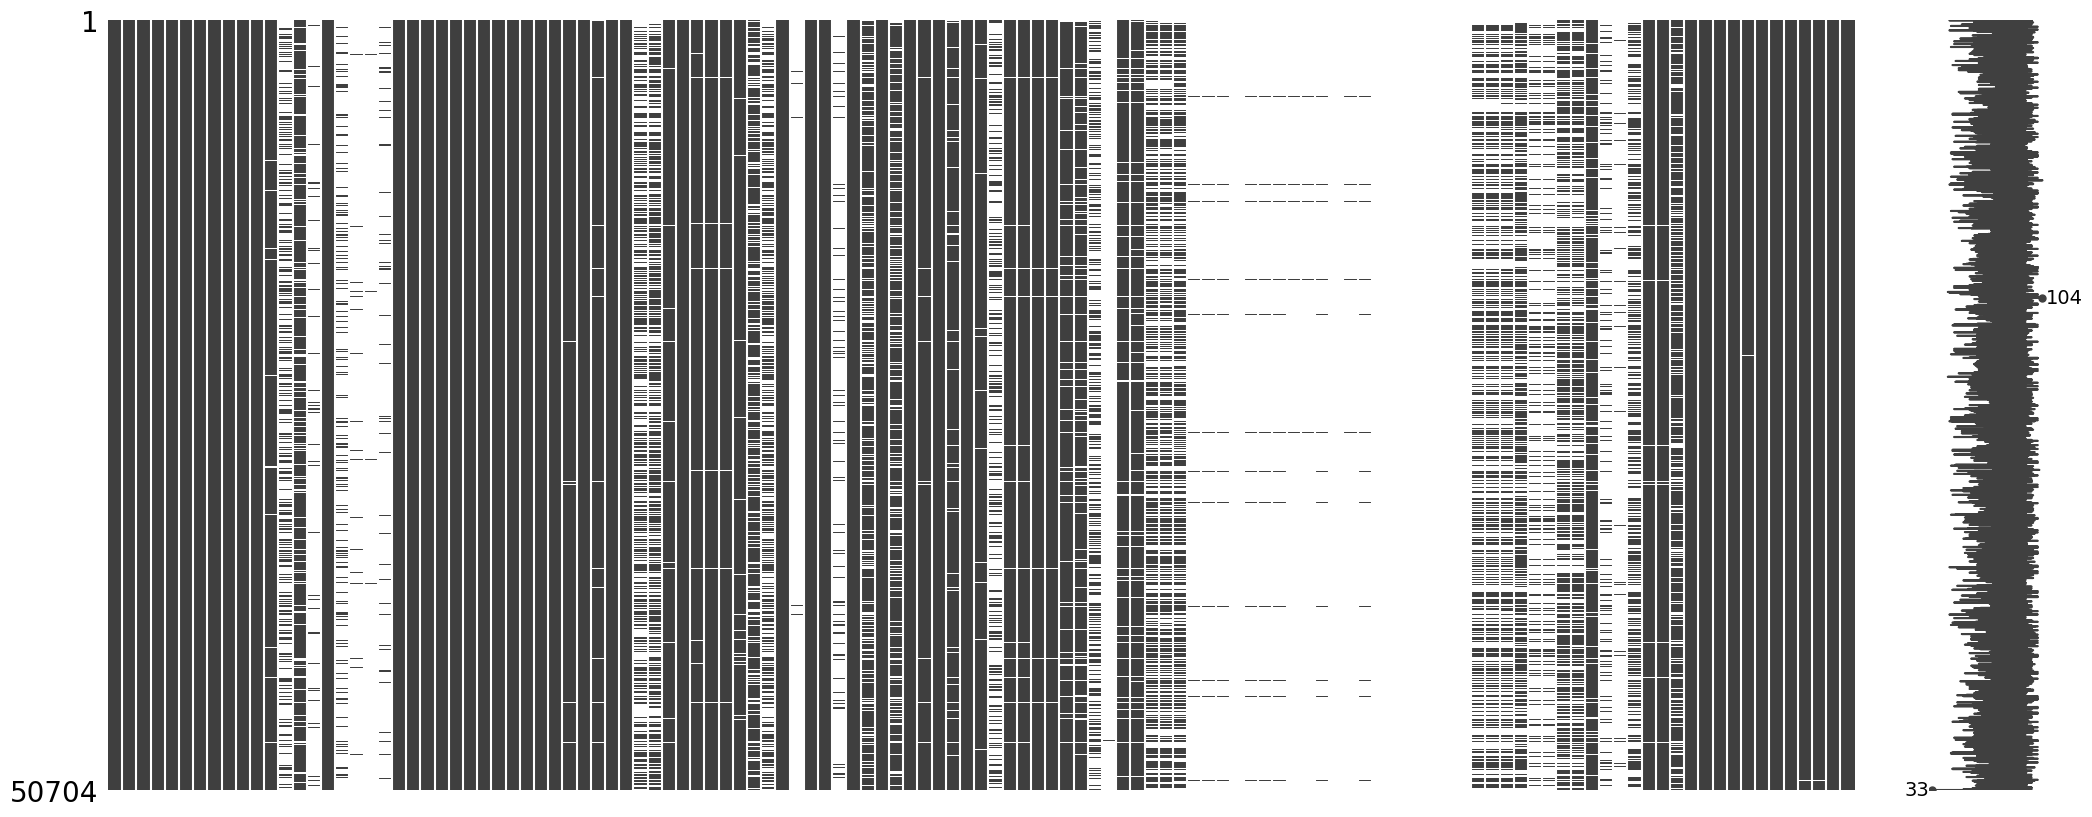

In [12]:
# Before further deleting uninformative columns, we nee to see correlation between features and the target
msno.matrix(new_df)

In [13]:
# seems no obvious Missing Not at Random(MNAR) pattern fron matrix above. 
# So we delete columns with more than 80% of number of samples.

count2, new_df = check_delete_row(new_df.dropna(thresh=len(new_df)*0.8, axis=1))

Number of columns: 71
Number of rows: 50704
Total columns have NaN value: 46
Column with highest NaN: {'BadgeDescription': 6605, 'TowingNoBrakes': 5200, 'FuelCombined': 4358, 'WarrantyKM': 2965, 'TowingBrakes': 2944}
Column with lowest NaN: {'Make': 0, 'Model': 0, 'MakeCode': 0, 'FamilyCode': 0, 'YearGroup': 0}
Total missing values: 39200


<AxesSubplot:>

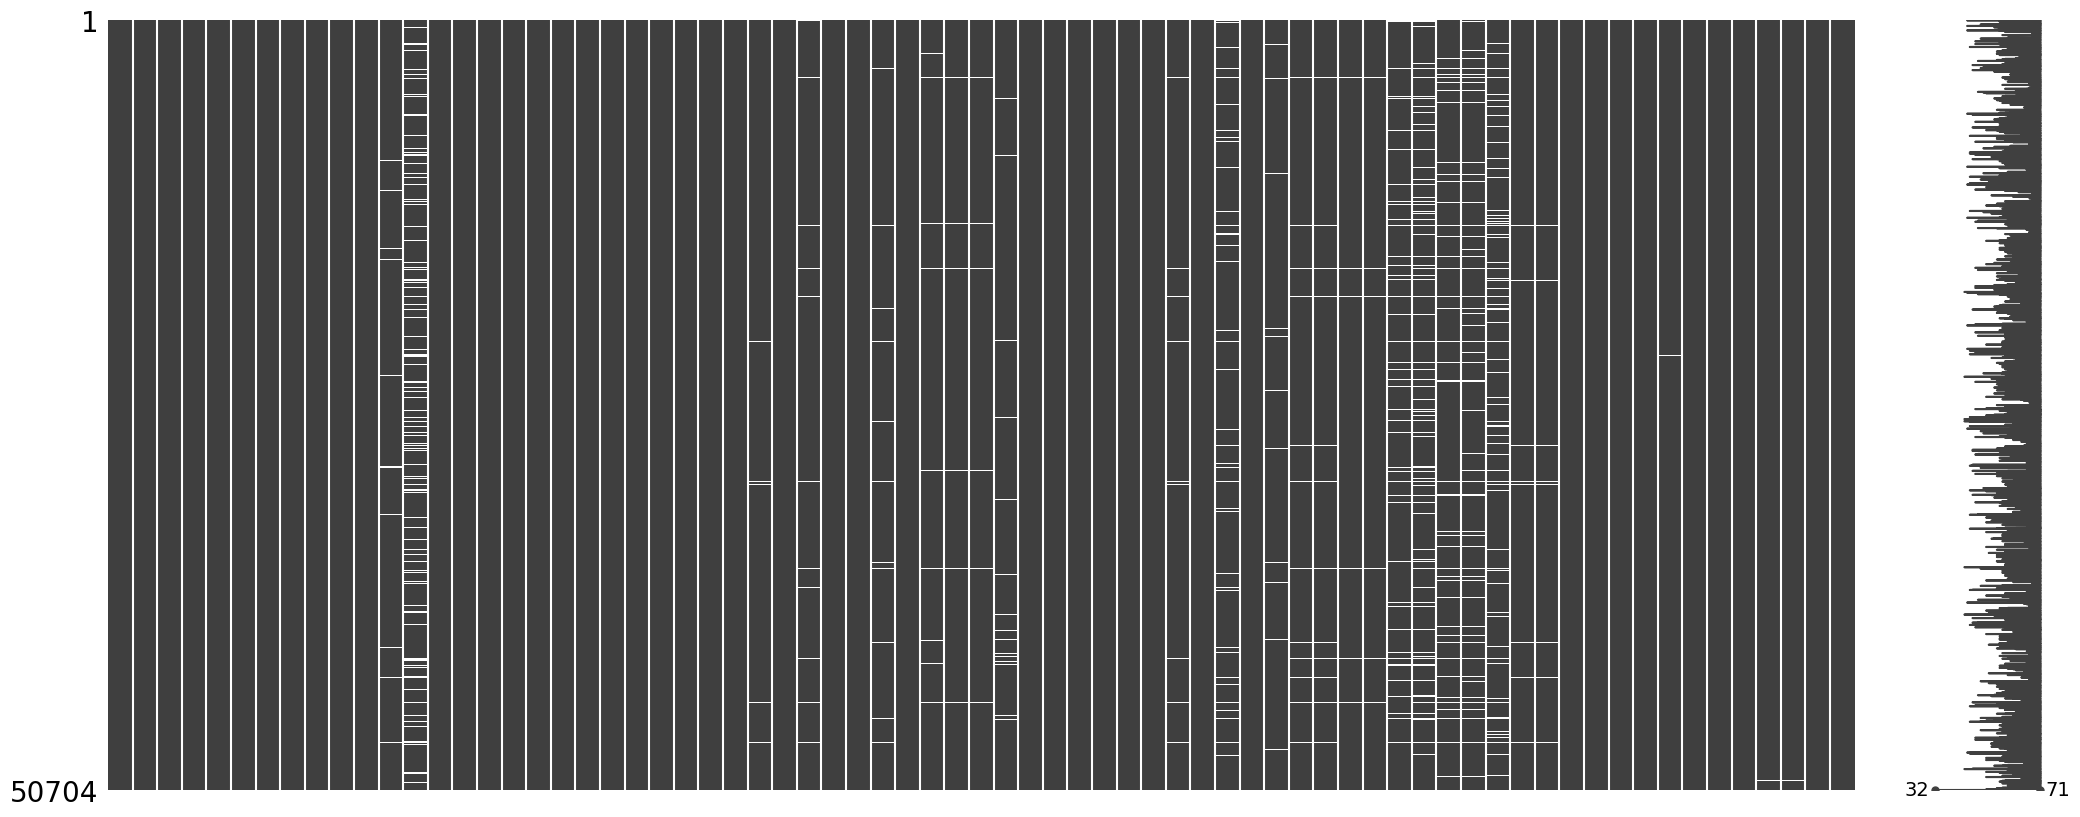

In [14]:
msno.matrix(new_df)

In [15]:
# Now lets have a look on Sold_Amount on missing value
new_df[new_df['Sold_Amount'].isna()]

,Make,Model,MakeCode,FamilyCode,YearGroup,MonthGroup,SequenceNum,Description,CurrentRelease,ImportFlag,LimitedEdition,Series,BadgeDescription,BodyStyleDescription,DriveDescription,DriveCode,GearTypeDescription,GearLocationDescription,GearNum,DoorNum,EngineSize,EngineDescription,Cylinders,FuelTypeDescription,InductionDescription,OptionCategory,CamDescription,EngineTypeDescription,FuelCapacity,FuelDeliveryDescription,MethodOfDeliveryDescription,VIN,WheelBase,Height,Length,Width,KerbWeight,Power,PowerRPMTo,Torque,TorqueRPMTo,SeatCapacity,BuildCountryOriginDescription,ValvesCylinder,EngineCycleDescription,EngineConfigurationDescription,EngineLocation,EngineNum,FrontTyreSize,RearTyreSize,FrontRimDesc,RearRimDesc,TowingBrakes,TowingNoBrakes,WarrantyYears,WarrantyKM,FuelCombined,VFactsClass,VFactsSegment,IsPPlateApproved,AverageKM,GoodKM,NewPrice,Colour,Branch,SaleCategory,Sold_Date,Compliance_Date,Age_Comp_Months,KM,Sold_Amount
30025,Holden,Commodore,HOLD,COMMODO,2006,1,0,VZ MY06 Executive Sedan 4dr. Auto 4sp 3.6i,F,L,F,VZ,Executive,Sedan,Rear Wheel Drive,RWD,Automatic,Floor,4.0,4,3565,3.6,6,Petrol - Unleaded ULP,Aspirated,PASS,DOHC with VVT,Piston,75.0,Multi-Point Injection,Electronic Sequential,6G1ZK52B#6L######,2789.0,1440.0,4876.0,1842.0,1568.0,172.0,6000.0,320.0,2800.0,5.0,AUSTRALIA,4.0,4 Stroke,V60,Front,HBA06 #######,205/65 R15,205/65 R15,15x6.0,15x6.0,2100.0,500.0,3.0,100000.0,11.0,Passenger,Large,T,275.0,165.0,33990.0,Quick Silver,Balcatta (WA),Tender,2009-04-01 00:00:00.000,02/2006,38.0,70701.0,NaN
44059,Ford,Falcon,FORD,FALCON,2005,10,27,BF Futura Sedan 4dr Spts Auto 4sp 4.0i,F,L,F,BF,Futura,Sedan,Rear Wheel Drive,RWD,Sports Automatic,Floor,4.0,4,3984,4.0,6,Petrol - Unleaded ULP,Aspirated,PASS,DOHC with VVT,Piston,68.0,Multi-Point Injection,Electronic Sequential,6FPAAAJGSW5*#####,2829.0,1444.0,4916.0,1864.0,1696.0,190.0,5250.0,383.0,2500.0,5.0,AUSTRALIA,4.0,4 Stroke,In-line,Front,JGSW5C#####,215/60 R16,215/60 R16,16x6.5,16x6.5,2300.0,750.0,3.0,100000.0,10.9,Passenger,Large,T,300.0,180.0,39175.0,Mercury,Balcatta (WA),Tender,2010-02-04 00:00:00.000,10/2005,52.0,40523.0,NaN
47153,Toyota,Camry,TOYO,CAMRY,2008,0,1,ACV40R Altise Sedan 4dr Auto 5sp 2.4i,F,L,F,ACV40R,Altise,Sedan,Front Wheel Drive,FWD,Automatic,Floor,5.0,4,2362,2.4,4,Petrol - Unleaded ULP,Aspirated,PASS,DOHC with VVT,Piston,70.0,Multi-Point Injection,Electronic Sequential,6T153BK400X######,2775.0,1480.0,4815.0,1820.0,1500.0,117.0,5700.0,218.0,4000.0,5.0,AUSTRALIA,4.0,4 Stroke,In-line,Front,2AZ-A######,215/60 R16,215/60 R16,16x6.5,16x6.5,1200.0,500.0,3.0,100000.0,9.9,Passenger,Medium,T,230.0,140.0,29990.0,White,Balcatta (WA),Tender,2010-02-04 00:00:00.000,09/2008,17.0,27217.0,NaN
50703,Toyota,Corolla,TOYO,COROLLA,2016,0,4,ZWE186R Hybrid Hatchback 5dr E-CVT 1.8i/60kW H...,F,L,F,ZWE186R,Hybrid,Hatchback,Front Wheel Drive,FWD,Constantly Variable Transmission,Floor,NaN,5,1798,1.8,4,Petrol - Unleaded ULP,Aspirated,PASS,DOHC with VVT,Piston - Electric,45.0,Multi-Point Injection,Electronic Sequential,JTNKN3JE40J######,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# 4 rows have missing value, so we delete it
new_df = new_df[new_df['Sold_Amount'].notna()]

In [17]:
new_df[new_df['Sold_Amount'].isna()]

,Make,Model,MakeCode,FamilyCode,YearGroup,MonthGroup,SequenceNum,Description,CurrentRelease,ImportFlag,LimitedEdition,Series,BadgeDescription,BodyStyleDescription,DriveDescription,DriveCode,GearTypeDescription,GearLocationDescription,GearNum,DoorNum,EngineSize,EngineDescription,Cylinders,FuelTypeDescription,InductionDescription,OptionCategory,CamDescription,EngineTypeDescription,FuelCapacity,FuelDeliveryDescription,MethodOfDeliveryDescription,VIN,WheelBase,Height,Length,Width,KerbWeight,Power,PowerRPMTo,Torque,TorqueRPMTo,SeatCapacity,BuildCountryOriginDescription,ValvesCylinder,EngineCycleDescription,EngineConfigurationDescription,EngineLocation,EngineNum,FrontTyreSize,RearTyreSize,FrontRimDesc,RearRimDesc,TowingBrakes,TowingNoBrakes,WarrantyYears,WarrantyKM,FuelCombined,VFactsClass,VFactsSegment,IsPPlateApproved,AverageKM,GoodKM,NewPrice,Colour,Branch,SaleCategory,Sold_Date,Compliance_Date,Age_Comp_Months,KM,Sold_Amount


#### Step 2: Variables similarity

In [18]:
for i in list(new_df.columns):
    n = new_df[i].unique()
    print(i)
    print(n)
    print(len(n))

Make
['Holden' 'Toyota' 'Ford' 'Mazda' 'Mitsubishi' 'Subaru' 'Nissan'
 'Volkswagen' 'Lexus' 'Land Rover' 'MINI' 'Hyundai' 'Mercedes-Benz'
 'Dodge' 'Daihatsu' 'Volvo' 'Honda' 'Renault' 'Jeep' 'Peugeot' 'Suzuki'
 'Isuzu' 'Proton' 'Audi' 'Saab' 'Daewoo' 'Porsche' 'SsangYong'
 'Great Wall' 'Chrysler' 'Alfa Romeo' 'De Tomaso' 'Citroen' 'Jaguar'
 'Hummer' 'smart' 'Fiat' 'SKODA' 'Tata' 'Chery' 'Eunos' 'Rover'
 'Aston Martin' 'Maserati' 'Seat' 'Pontiac' 'Lotus' 'Lamborghini'
 'Daimler' 'Ferrari' 'Bentley' 'Opel']
52
Model
['Commodore' 'RAV4' 'Tarago' 'Camry' 'Falcon' '626' 'Ute' 'Pajero'
 'Falcon Ute' 'Hiace' 'Aurion' 'Territory' 'Forester' 'Fairlane'
 'Outlander' 'Navara' 'Epica' 'Magna' 'Corolla' 'Ranger' 'Captiva'
 'Berlina' 'Statesman' 'Liberty' 'Verada' 'Landcruiser Prado' 'Prius C'
 'Impreza' 'Transporter' 'Calais' 'Avensis Verso' 'Lancer' 'Echo' 'Rodeo'
 'Hilux' 'Caprice' 'NX' 'Fiesta' 'Amarok' 'Outback' 'X-Trail' 'CX-9'
 'Range Rover Sport' 'Triton' 'Hatch' 'Landcruiser' 'Tiida' 'Maxim

In [19]:
# After went through the data there are 4 columns we can delete Make_Code.
# Family_Code (similar), CurrentRelease & ImportFlag (only have single value)
count2, new_df = check_delete_row(new_df.drop(['MakeCode', 'FamilyCode', 'CurrentRelease', 'ImportFlag'], axis=1))

Number of columns: 67
Number of rows: 50700
Total columns have NaN value: 35
Column with highest NaN: {'BadgeDescription': 6605, 'TowingNoBrakes': 5199, 'FuelCombined': 4357, 'WarrantyKM': 2964, 'TowingBrakes': 2943}
Column with lowest NaN: {'Make': 0, 'Model': 0, 'YearGroup': 0, 'MonthGroup': 0, 'SequenceNum': 0}
Total missing values: 39158


#### Step 3: Data imputation and transformation

In [20]:
new_df[new_df.columns[new_df.isna().any()]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50700 entries, 0 to 50702
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Series                          49849 non-null  object 
 1   BadgeDescription                44095 non-null  object 
 2   CamDescription                  50482 non-null  object 
 3   FuelCapacity                    49888 non-null  float64
 4   MethodOfDeliveryDescription     50678 non-null  object 
 5   VIN                             50122 non-null  object 
 6   WheelBase                       50557 non-null  float64
 7   Height                          49982 non-null  float64
 8   Length                          50042 non-null  float64
 9   Width                           50044 non-null  float64
 10  KerbWeight                      49167 non-null  float64
 11  Power                           50589 non-null  float64
 12  PowerRPMTo                      

In [21]:
# The missing values columns have float and objet types, so to make it simple use 'most frequent' type data imputation
imputer = SimpleImputer(strategy='most_frequent')
new_df.iloc[:,:] = imputer.fit_transform(new_df)

In [22]:
# list of columns with object datatype
obj_list = list(new_df.select_dtypes('object').columns)

In [23]:
# label encoding and save encoding for test data

le = LabelEncoder()
#trained_le = le.fit(new_df)
new_df[obj_list] = new_df[obj_list].astype(str)
new_df[obj_list] = new_df[obj_list].apply(le.fit_transform)
dump(le, open('encoder.pkl', 'wb'))

In [24]:
x_train = new_df[new_df.columns.drop('Sold_Amount')].to_numpy()
y_train = new_df['Sold_Amount'].to_numpy()

### Randon Forest regression

#### Hyperparameter tuning

Resource: https://www.kaggle.com/code/arjunprasadsarkhel/simple-random-forest-with-hyperparameter-tuning

#### Warning! this process may take more than 10 minutes depend on your machine, avoid this step if you just want to see the results

In [26]:
n_estimators = [5,20,50,100, 300, 500] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10, 50] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4, 10] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
regr = RandomForestRegressor()
#regr.fit(x_train, y_train)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = regr, param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

In [ ]:
## This process will take 10 minutes or longer!!!!!

rf_random.fit(x_train, y_train)

In [ ]:
print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

#### Training

In [ ]:
scaler = Pipeline(steps=[('scaler', StandardScaler())])
#randmf = RandomForestRegressor(n_estimators = 100, min_samples_split = 2, min_samples_leaf= 1, max_features = 'auto', max_depth= 120, bootstrap=True)
model = Pipeline(steps=([('RFregression', RandomForestRegressor(n_estimators = 100, 
                                                                                    min_samples_split = 10, min_samples_leaf= 1, max_features = 'auto', 
                                                                                    max_depth= 80, bootstrap=True))]))
#randmf = RandomForestRegressor(n_estimators = 50, min_samples_split = 2, min_samples_leaf= 3, max_features = 'auto', max_depth= 60, bootstrap=True)
model.fit(x_train, y_train)

In [ ]:
pred = model.predict(x_train)
accuracy_train = model.score(x_train, y_train)
score_train = explained_variance_score(y_train, pred)
r2_train = r2_score(y_train, pred)
print(accuracy_train)
print(score_train)
print(r2_train)

### Record experiment and save model to mlflow

In [ ]:
model_name = "clf-model"

with mlflow.start_run() as run:
    run_num = run.info.run_id
    model_uri = "runs:/{run_id}/{artifact_path}".format(run_id=run_num, artifact_path=model_name)

    mlflow.log_metric('accuracy_train', accuracy_train)
    mlflow.log_metric('explained_variance_score', score_train)
    mlflow.log_metric('r2', r2_train)
    mlflow.sklearn.log_model(model, model_name)
  #mlflow.sklearn.save_model(model, "clf-model")

    model_details = mlflow.register_model(
        model_uri=model_uri,
        name=model_name)

In [ ]:
model_version_infos = client.search_model_versions("name = '%s'" % model_name)
new_model_version = max([model_version_info.version for model_version_info in model_version_infos])

In [ ]:
from mlflow.entities.model_registry.model_version_status import ModelVersionStatus

def wait_model_transition(model_name, model_version, stage):
  client = MlflowClient()
  for _ in range(10):
    model_version_details = client.get_model_version(
      name=model_name,
      version=model_version,
    )
    status = ModelVersionStatus.from_string(model_version_details.status)
    print("Model status: %s" % ModelVersionStatus.to_string(status))
    if status == ModelVersionStatus.READY:
      client.transition_model_version_stage(
          name=model_name,
          version=model_version,
          stage=stage,
        )
      break
    time.sleep(1)

In [ ]:
try:
  wait_model_transition(model_name, int(new_model_version)-1, "None")
except:
  pass

wait_model_transition(model_name, new_model_version, "Staging")

In [ ]:
new_model_version

In [ ]:
client.update_model_version(
  name=model_name,
  version=new_model_version,
  description="This model is a random forest regression for Datium car auto sale data."
)

In [ ]:
import mlflow.pyfunc

model_name = "clf-model"
stage = 'Staging'

## download model
loaded_model = mlflow.pyfunc.load_model(
    model_uri=f"models:/{model_name}/{stage}"
)

### Inferencing with test data

In [ ]:
col_list = list(new_df.columns) # get column list from train data

In [ ]:
new_test = test_dat[col_list] # select feature columns

In [ ]:
# load model and encoder

encoder = load(open('encoder.pkl', 'rb'))

In [ ]:
new_test.isna().any()

In [ ]:
new_test.iloc[:,:] = imputer.fit_transform(new_test)

In [ ]:
new_test[obj_list] = new_test[obj_list].astype(str)
new_test[obj_list] = new_test[obj_list].apply(encoder.fit_transform)

In [ ]:
x_test = new_test[new_test.columns.drop('Sold_Amount')].to_numpy()
y_test = new_test['Sold_Amount'].to_numpy()

In [ ]:
predicted_probs = loaded_model.predict(x_test)
predicted_probs

In [ ]:
#yhat = rfmodel.predict(x_test)
# evaluate accuracy
acc = explained_variance_score(y_test, predicted_probs)
r2 = r2_score(y_test, predicted_probs)
print('Test Accuracy:', acc)
print('R2 Score:', r2)